In [1]:
import numpy as np
import xgboost as xgb
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

## Construct a simulated data set for testing monotonic constraintsx

In [2]:
N, K = (1000, 2)
pi = 3.14159

In [3]:
X = np.random.random(size=(N, K))
y = (5*X[:, 0] + np.sin(5*2*pi*X[:, 0])
     - 5*X[:, 1] - np.cos(5*2*pi*X[:, 1])
     #+ 0.01*np.sin(5*2*pi*X[:, 0])*np.cos(5*2*pi*X[:, 1])
     + np.random.normal(loc=0.0, scale=0.01, size=N))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

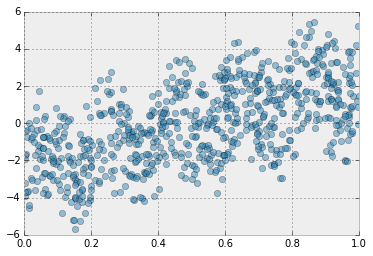

In [5]:
plt.plot(X_train[:, 0], y_train, 'o', alpha = 0.5)

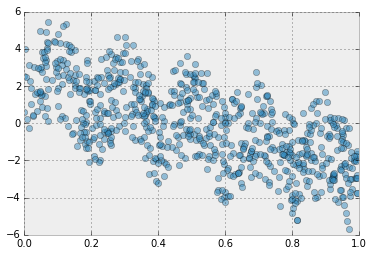

In [6]:
plt.plot(X_train[:, 1], y_train, 'o', alpha = 0.5)

## Fit a xgboost model - Unconstrained

In [7]:
params = {
    'max_depth': 2,
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'rmse',
    'seed': 154
}

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an **increasing** trend.

In [8]:
dtrain = xgb.DMatrix(X_train[:, [0]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [0]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.12846	eval-rmse:2.29167
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.05019	eval-rmse:2.20947
[2]	train-rmse:1.9838	eval-rmse:2.1381
[3]	train-rmse:1.92732	eval-rmse:2.07759
[4]	train-rmse:1.88045	eval-rmse:2.028
[5]	train-rmse:1.84091	eval-rmse:1.98507
[6]	train-rmse:1.80795	eval-rmse:1.94885
[7]	train-rmse:1.78037	eval-rmse:1.9175
[8]	train-rmse:1.75772	eval-rmse:1.89229
[9]	train-rmse:1.73873	eval-rmse:1.87037
[10]	train-rmse:1.72314	eval-rmse:1.85293
[11]	train-rmse:1.71013	eval-rmse:1.8377
[12]	train-rmse:1.69889	eval-rmse:1.82702
[13]	train-rmse:1.6898	eval-rmse:1.81627
[14]	train-rmse:1.68181	eval-rmse:1.80717
[15]	train-rmse:1.67499	eval-rmse:1.80066
[16]	train-rmse:1.66912	eval-rmse:1.79292
[17]	train-rmse:1.66384	eval-rmse:1.78699
[18]	train-rmse:1.65875	eval-rmse:1.78026
[19]	train-rmse:1.65483	eval-rmse:1.77579
[20]	train-rmse:1.65099	eval-rmse:

In [9]:
def plot_one_feature_prediction(bst, X, y, title):
    """For one-feature model, plot data and prediction."""
    
    x_scan = np.linspace(0, 1, 100)
    x_plot = xgb.DMatrix(x_scan.reshape((len(x_scan),1)))
    y_plot = bst.predict(x_plot, ntree_limit = bst.best_ntree_limit)

    plt.plot(x_scan, y_plot, color = 'black')
    plt.plot(X, y, 'o', alpha = 0.25)

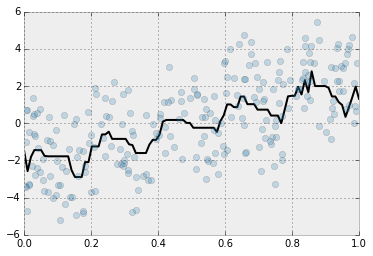

In [10]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 0], y_test, "")

Add a monotonic constraint - constrain feature to be fit monotonically.

In [11]:
params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.12846	eval-rmse:2.29167
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.05019	eval-rmse:2.20947
[2]	train-rmse:1.9838	eval-rmse:2.1381
[3]	train-rmse:1.92732	eval-rmse:2.07759
[4]	train-rmse:1.88045	eval-rmse:2.028
[5]	train-rmse:1.84091	eval-rmse:1.98507
[6]	train-rmse:1.80795	eval-rmse:1.94885
[7]	train-rmse:1.78037	eval-rmse:1.9175
[8]	train-rmse:1.75772	eval-rmse:1.89229
[9]	train-rmse:1.73873	eval-rmse:1.87037
[10]	train-rmse:1.72318	eval-rmse:1.85321
[11]	train-rmse:1.71037	eval-rmse:1.83821
[12]	train-rmse:1.69967	eval-rmse:1.82507
[13]	train-rmse:1.69086	eval-rmse:1.81425
[14]	train-rmse:1.68368	eval-rmse:1.8057
[15]	train-rmse:1.67779	eval-rmse:1.79835
[16]	train-rmse:1.67291	eval-rmse:1.7918
[17]	train-rmse:1.66892	eval-rmse:1.78648
[18]	train-rmse:1.66566	eval-rmse:1.78257
[19]	train-rmse:1.66295	eval-rmse:1.77895
[20]	train-rmse:1.66069	eval-rmse:

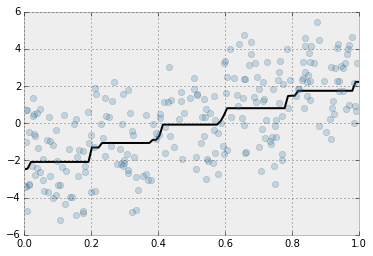

In [12]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 0], y_test, "")

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an **decreasing** trend.

In [13]:
dtrain = xgb.DMatrix(X_train[:, [1]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [1]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.11364	eval-rmse:2.27667
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.02279	eval-rmse:2.18106
[2]	train-rmse:1.94531	eval-rmse:2.09685
[3]	train-rmse:1.87969	eval-rmse:2.02744
[4]	train-rmse:1.82275	eval-rmse:1.96361
[5]	train-rmse:1.77562	eval-rmse:1.91502
[6]	train-rmse:1.73571	eval-rmse:1.87313
[7]	train-rmse:1.70122	eval-rmse:1.8328
[8]	train-rmse:1.67277	eval-rmse:1.80124
[9]	train-rmse:1.64865	eval-rmse:1.77217
[10]	train-rmse:1.62886	eval-rmse:1.75045
[11]	train-rmse:1.61188	eval-rmse:1.73001
[12]	train-rmse:1.59785	eval-rmse:1.71335
[13]	train-rmse:1.58577	eval-rmse:1.70044
[14]	train-rmse:1.57521	eval-rmse:1.68974
[15]	train-rmse:1.56611	eval-rmse:1.68027
[16]	train-rmse:1.55852	eval-rmse:1.67152
[17]	train-rmse:1.55014	eval-rmse:1.66213
[18]	train-rmse:1.5444	eval-rmse:1.65615
[19]	train-rmse:1.53797	eval-rmse:1.64978
[20]	train-rmse:1.53366	eval-

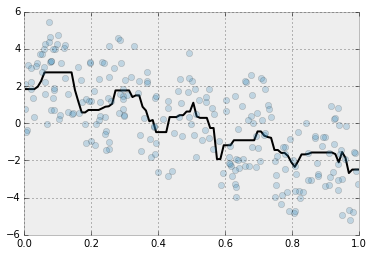

In [14]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 1], y_test, "")

In [15]:
params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(-1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.11364	eval-rmse:2.27667
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.02279	eval-rmse:2.18106
[2]	train-rmse:1.94531	eval-rmse:2.09685
[3]	train-rmse:1.87969	eval-rmse:2.02744
[4]	train-rmse:1.82275	eval-rmse:1.96361
[5]	train-rmse:1.77562	eval-rmse:1.91502
[6]	train-rmse:1.73571	eval-rmse:1.87313
[7]	train-rmse:1.70122	eval-rmse:1.8328
[8]	train-rmse:1.67277	eval-rmse:1.80124
[9]	train-rmse:1.64865	eval-rmse:1.77217
[10]	train-rmse:1.62886	eval-rmse:1.75045
[11]	train-rmse:1.61213	eval-rmse:1.7295
[12]	train-rmse:1.59841	eval-rmse:1.7133
[13]	train-rmse:1.5868	eval-rmse:1.69966
[14]	train-rmse:1.57723	eval-rmse:1.68855
[15]	train-rmse:1.56936	eval-rmse:1.67868
[16]	train-rmse:1.56277	eval-rmse:1.6711
[17]	train-rmse:1.55739	eval-rmse:1.66319
[18]	train-rmse:1.55277	eval-rmse:1.65716
[19]	train-rmse:1.54911	eval-rmse:1.65276
[20]	train-rmse:1.54595	eval-rms

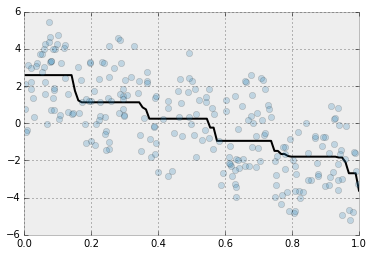

In [16]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 1], y_test, "")